In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from PIL import UnidentifiedImageError
from collections import Counter
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers


In [2]:
data_dir = r'C:\Users\varun\Downloads\archive\dataset'

In [3]:
recyclable_folder = os.path.join(data_dir, 'recyclable')
non_recyclable_folder = os.path.join(data_dir, 'non-recyclable')

In [4]:
print(recyclable_folder,non_recyclable_folder)

C:\Users\dhanu\Downloads\WasteDevelopment\dataset\recyclable C:\Users\dhanu\Downloads\WasteDevelopment\dataset\non-recyclable


In [5]:
#Exploring data

def load_images_from_folder(folder):
    images = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(subdir, file))
                if img is not None:
                    images.append(img)
    return images





In [6]:

recyclable_images = load_images_from_folder('dataset/recyclable')

In [8]:
non_recyclable_images = load_images_from_folder('dataset/non_recyclable')

In [9]:
total_recyclable_images = len(recyclable_images)
total_non_recyclable_images = len(non_recyclable_images)

print("Total Recyclable Images:", total_recyclable_images)
print("Total Non-Recyclable Images:", total_non_recyclable_images)

Total Recyclable Images: 10710
Total Non-Recyclable Images: 7810


In [10]:
labels = ["Recyclable","Non-Recyclable"]
sizes = [total_recyclable_images, total_non_recyclable_images]


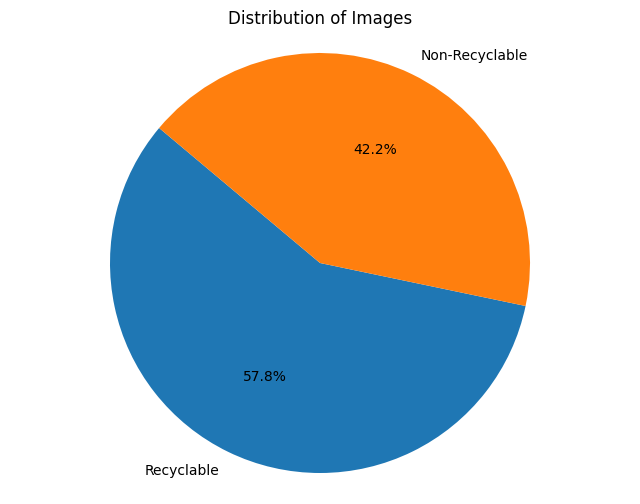

In [11]:
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Images')
plt.show()

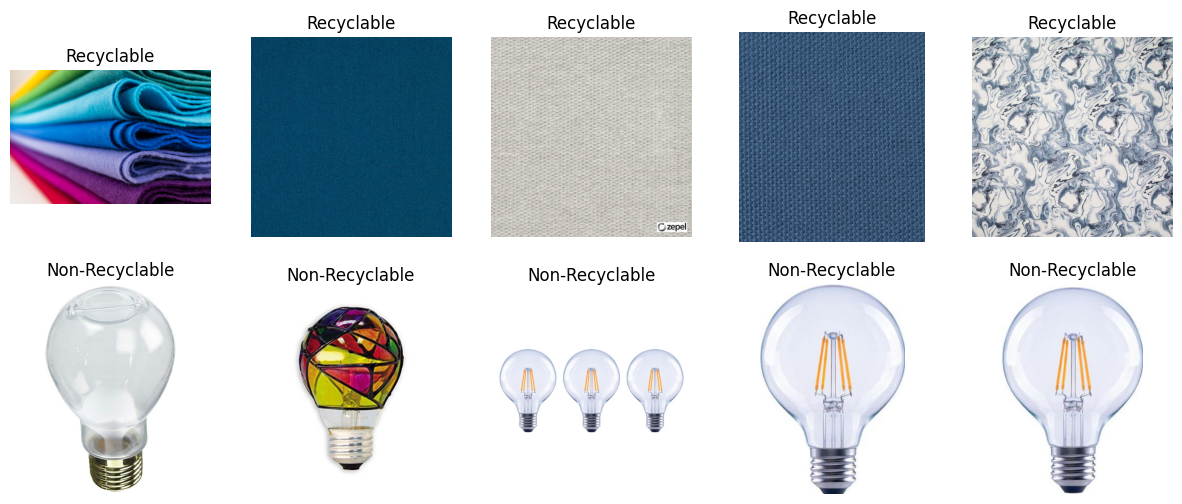

In [12]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(cv2.cvtColor(recyclable_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title('Recyclable')
    axes[0, i].axis('off')
    axes[1, i].imshow(cv2.cvtColor(non_recyclable_images[i], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title('Non-Recyclable')
    axes[1, i].axis('off')
plt.show()


In [13]:
# Analyze image dimensions
recyclable_dimensions = [img.shape[:2] for img in recyclable_images]
non_recyclable_dimensions = [img.shape[:2] for img in non_recyclable_images]

In [ ]:
recyclable_dimensions,non_recyclable_dimensions

In [ ]:
recyclable_counter = Counter(recyclable_dimensions)
non_recyclable_counter = Counter(non_recyclable_dimensions)

print("Recyclable Image Dimensions:")
print(recyclable_counter)
print("Non-Recyclable Image Dimensions:")
print(non_recyclable_counter)

# Data Loading

In [16]:
def load_images_from_folders(folder):
    images = []
    labels = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                label = os.path.basename(subdir)
                img = cv2.imread(os.path.join(subdir, file))
                if img is not None:
                    img = cv2.resize(img, (200, 200)) # Resize images to a uniform size
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [17]:
recyclable_images, recyclable_labels = load_images_from_folders('dataset/recyclable')

non_recyclable_images, non_recyclable_labels = load_images_from_folders('dataset/non_recyclable')


In [18]:
def resize_images_from_folder(folder, target_size=(200, 200)):
    images = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, target_size)
                    images.append(img)
    return np.array(images)

In [20]:
recyclable_images = resize_images_from_folder('dataset/recyclable')
non_recyclable_images = resize_images_from_folder('dataset/non_recyclable')

print("Recyclable Image Shapes:", Counter([img.shape[:2] for img in recyclable_images]))
print("Non-Recyclable Image Shapes:", Counter([img.shape[:2] for img in non_recyclable_images]))

Recyclable Image Shapes: Counter({(200, 200): 10710})
Non-Recyclable Image Shapes: Counter({(200, 200): 7810})


In [22]:
# Combine recyclable and non-recyclable data
all_images = np.concatenate((recyclable_images, non_recyclable_images), axis=0)
all_labels = np.concatenate((recyclable_labels, non_recyclable_labels), axis=0)


print(all_labels)

['recyclable' 'recyclable' 'recyclable' ... 'non_recyclable'
 'non_recyclable' 'non_recyclable']


In [23]:
# One-hot encoding labels
all_labels = np.where(all_labels == 'recyclable', 1, 0)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [25]:
len(X_train), len(X_test)

(14816, 3704)

In [26]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)






In [27]:


train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [28]:
train_generator,test_generator

(<keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x1ae24363eb0>,
 <keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x1ae243fa050>)

# Model Building

In [29]:
"""model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
"""



model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


c:\Users\dhanu\.conda\envs\idk_gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),  
              metrics=['accuracy'])


In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,795,457 (25.92 MB)

 Trainable params: 6,795,457 (25.92 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Model Training
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=len(X_test) // 32)


Epoch 1/50


c:\Users\dhanu\.conda\envs\idk_gpu\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 240s 512ms/step - accuracy: 0.5597 - loss: 0.7120 - val_accuracy: 0.5872 - val_loss: 0.6756
Epoch 2/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.3621
Epoch 3/50


c:\Users\dhanu\.conda\envs\idk_gpu\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


463/463 ━━━━━━━━━━━━━━━━━━━━ 226s 486ms/step - accuracy: 0.5657 - loss: 0.6831 - val_accuracy: 0.5870 - val_loss: 0.6726
Epoch 4/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4583 - val_loss: 0.3455
Epoch 5/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 459s 991ms/step - accuracy: 0.5834 - loss: 0.6749 - val_accuracy: 0.5954 - val_loss: 0.6690
Epoch 6/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.3251
Epoch 7/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 252s 542ms/step - accuracy: 0.5867 - loss: 0.6729 - val_accuracy: 0.6043 - val_loss: 0.6645
Epoch 8/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5833 - val_loss: 0.3355
Epoch 9/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 244s 523ms/step - accuracy: 0.5847 - loss: 0.6700 - val_accuracy: 0.6149 - val_loss: 0.6548
Epoch 10/50
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.

In [35]:
# Model Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)



116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.5662 - loss: 25.2964
Test Accuracy: 0.571814239025116


In [36]:
# Save the model
model.save('model_save/recyclable_classifier_model.h5')


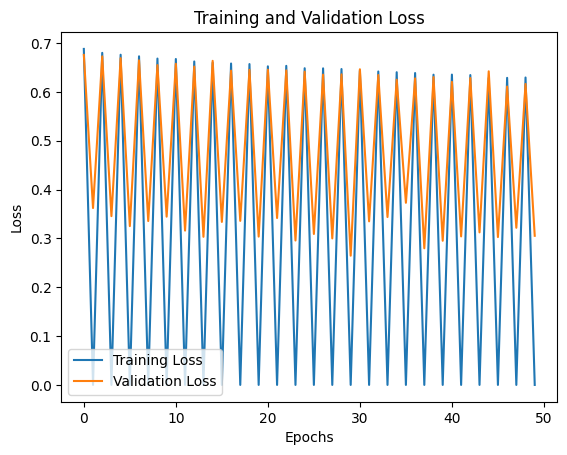

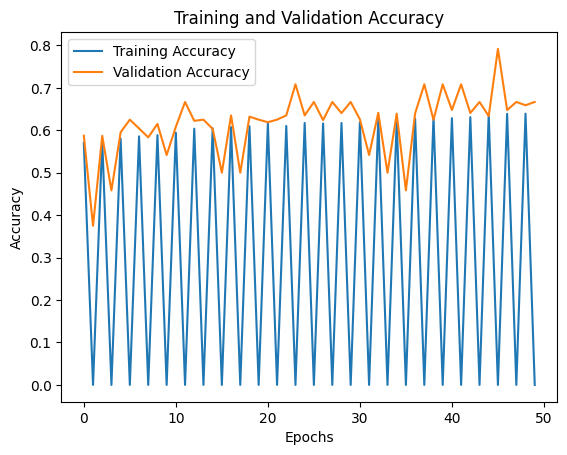

In [37]:

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Model Prediction

In [38]:
# Load and preprocess the sample image
sample_image_path = 'dataset/recyclable/fabric_9.png'
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.resize(sample_image, (200, 200))  # Resize image to match model input size
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(sample_image)

# Decode prediction (assuming binary classification)
if prediction[0][0] > 0.5:
    print("Predicted: Recyclable")
else:
    print("Predicted: Non-recyclable")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted: Recyclable
